# Proposing inorganic synthesis conditions for hypothetical zeolites

In this notebook, we train and evaluate classifiers to propose inorganic synthesis conditions to hypothetical zeolites. We use the distance matrix between each hypothetical framework to all known frameworks as input, and then filter structures based on their energy, structural patterns, etc.

In [1]:
import os
import tqdm
import random
import pickle
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

import shap
import xgboost as xgb
from scipy import stats
from zeo_amd.classify import train_classifier, get_datasets, get_metrics, get_best_classifier
from zeo_amd.plotting import savefig

plt.style.use("jupyter")

In [2]:
dm = pd.read_csv("../data/iza_dm.csv", index_col=0)

xgb_file = "../data/xgb_ensembles_hyp.pkl"
hyp = pd.read_csv("../data/hyp_dm.csv", index_col=0)

cols = sorted(list(set(hyp.columns) & set(dm.columns)))

dm = dm.loc[cols, cols]
hyp = hyp[cols]

synth = pd.read_csv("../data/synthesis_fraction.csv", index_col=0)
synth = synth.loc[dm.index]
hfeat = pd.read_csv("../data/hyp_features.csv", index_col=0).set_index("id")

In [3]:
X = dm.values
X_norm = (X - X.mean(0, keepdims=True)) / X.std(0, keepdims=True)

## Training classifiers

In [12]:
MIN_SYNTHESIS = 0.25
NUM_ROUNDS = 100
INORGANICS = ['Al', 'B', "Be", 'Ca', 'Co', 'F', 'Ga', 'Ge', 'K', 'Mg', 'Na', 'P', 'Si', 'Zn']

In [13]:
if not os.path.exists(xgb_file):
    ensemble = {}

    for _label in INORGANICS:
        y = (synth[_label] > MIN_SYNTHESIS).values

        for n in range(NUM_ROUNDS):
            clf = get_best_classifier()

            X_train, X_test, y_train, y_test = get_datasets(
                X, y, test_size=0.1, balanced=True, random_seed=143,
            )

            clf.fit(X_train, y_train)

            ensemble[_label] = ensemble.get(_label, []) + [clf]

        with open(xgb_file, "wb") as f:
            pickle.dump(ensemble, f)

## Obtaining the predictions of inorganic labels for all hypothetical zeolites

In [16]:
with open(xgb_file, "rb") as f:
    ensemble = pickle.load(f)

In [17]:
predictions = {}

for label, clf_list in tqdm.tqdm(ensemble.items()):
    values = [
        clf.predict(hyp.values)
        for clf in clf_list
    ]
    predictions[label] = values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [02:34<00:00, 11.06s/it]


In [68]:
mean_predictions = pd.DataFrame({
    label: np.stack(preds).mean(0)
    for label, preds in predictions.items()
}, index=hyp.index)

std_predictions = pd.DataFrame({
    label: np.stack(preds).std(0)
    for label, preds in predictions.items()
}, index=hyp.index)

final = pd.concat([mean_predictions, hfeat], axis=1)

In [113]:
final.to_csv("../data/hyp_predictions.csv")

## Filtering structures based on energy

In [ ]:
final = pd.read_csv("../data/hyp_predictions.csv", index_col=0)

In [185]:
_df = pd.concat([hyp, final], axis=1)
_df = _df.loc[
    (_df["Ge"] == 1)
    & (_df['density'] < 17)
    & (_df['density'] > 14)
    & (_df["Si"] > 0.5)
].sort_values("relative_energy")
_df.iloc[:10]

,ABW,ACO,AEI,AEL,AEN,AET,AFG,AFI,AFN,AFO,...,Ge,K,Mg,Na,P,Si,Zn,formula,relative_energy,density
38882,0.455355,0.652427,0.504240,0.374854,0.433941,0.344297,0.332779,0.283869,0.204341,0.342681,...,1.0,0.34,0.29,0.31,0.06,1.0,0.02,O32Si16,11.313132,16.884486
298667,0.560747,0.729200,0.525300,0.510276,0.605115,0.484656,0.305123,0.444323,0.377220,0.504227,...,1.0,0.10,0.53,0.58,0.01,1.0,0.00,O192Si96,11.722785,15.926930
64550,0.618875,0.677901,0.494389,0.496749,0.598493,0.466361,0.301837,0.415799,0.370573,0.501518,...,1.0,0.05,0.57,0.51,0.01,1.0,0.02,O64Si32,12.460934,15.868621
60436,0.650715,0.627783,0.448442,0.517490,0.679386,0.494599,0.371775,0.402913,0.448513,0.582412,...,1.0,0.00,0.59,0.32,0.01,1.0,0.04,O56Si28,12.478575,15.682772
267067,0.580931,0.585577,0.454771,0.441841,0.627941,0.456038,0.336086,0.325455,0.400557,0.535190,...,1.0,0.02,0.58,0.33,0.01,1.0,0.03,O160Si80,12.483791,14.673356
186326,0.577256,0.632474,0.501723,0.466796,0.562407,0.472056,0.294966,0.427734,0.334511,0.484538,...,1.0,0.18,0.59,0.45,0.01,1.0,0.01,O144Si72,12.703058,16.878092
330388,0.548099,0.684326,0.532745,0.409314,0.612213,0.440460,0.320508,0.334120,0.384979,0.519612,...,1.0,0.05,0.48,0.45,0.03,1.0,0.01,O240Si120,12.729951,15.026847
281322,0.622348,0.646229,0.476571,0.506192,0.600527,0.475634,0.314761,0.417774,0.364277,0.511397,...,1.0,0.06,0.57,0.23,0.01,1.0,0.03,O256Si128,12.748207,15.770404
274416,0.532932,0.639471,0.469179,0.444948,0.539508,0.416450,0.342116,0.374506,0.303389,0.446407,...,1.0,0.23,0.57,0.59,0.00,1.0,0.01,O144Si72,12.947451,15.877204
318264,0.648954,0.662660,0.471924,0.532288,0.617838,0.494639,0.314185,0.435801,0.387245,0.524738,...,1.0,0.02,0.60,0.29,0.00,1.0,0.01,O128Si64,12.951377,15.632587


## Example: comparing against LTA

In [115]:
bad_LTA = 313030
good_LTA = 308105

In [170]:
_df = pd.concat([hyp, final], axis=1)
_df = _df.loc[_df["relative_energy"] < 18]
_df = _df.sort_values("LTA")
_df = _df.iloc[:1000]

In [171]:
_df.loc[_df["Si"] > 0.98].sort_values("relative_energy").iloc[:20][["LTA", "relative_energy", "density"] + INORGANICS]

,LTA,relative_energy,density,Al,B,Be,Ca,Co,F,Ga,Ge,K,Mg,Na,P,Si,Zn
85225,0.345681,11.246513,15.693999,1.00,0.04,0.23,0.46,0.92,0.32,0.64,0.24,0.02,0.90,0.04,0.86,1.00,0.72
321606,0.381544,12.016336,16.104390,1.00,0.04,0.25,0.46,0.64,0.34,0.45,0.19,0.10,0.87,0.24,0.94,1.00,0.68
95119,0.369655,12.051015,16.103601,1.00,0.02,0.31,0.46,0.72,0.26,0.50,0.25,0.09,0.85,0.25,0.96,1.00,0.78
312407,0.337327,12.599019,15.394686,1.00,0.04,0.25,0.43,0.92,0.25,0.70,0.24,0.02,0.92,0.03,0.92,1.00,0.79
330640,0.364434,12.811023,15.938943,1.00,0.03,0.34,0.36,0.78,0.33,0.60,0.39,0.07,0.84,0.04,0.93,1.00,0.83
307538,0.335684,12.854630,15.284165,1.00,0.03,0.33,0.46,0.94,0.21,0.67,0.23,0.02,0.92,0.03,0.96,1.00,0.88
315006,0.347809,12.855342,15.644830,1.00,0.07,0.21,0.28,0.96,0.66,0.79,0.38,0.02,0.83,0.01,0.80,1.00,0.72
321882,0.353847,12.991619,15.947016,1.00,0.03,0.36,0.44,0.69,0.27,0.60,0.21,0.10,0.82,0.21,0.97,1.00,0.84
327044,0.357459,13.073280,15.828817,1.00,0.03,0.37,0.38,0.74,0.28,0.64,0.36,0.10,0.83,0.10,0.93,1.00,0.88
315054,0.390797,13.088183,15.810205,0.99,0.09,0.10,0.30,0.84,0.91,0.76,0.70,0.06,0.76,0.10,0.98,1.00,0.73


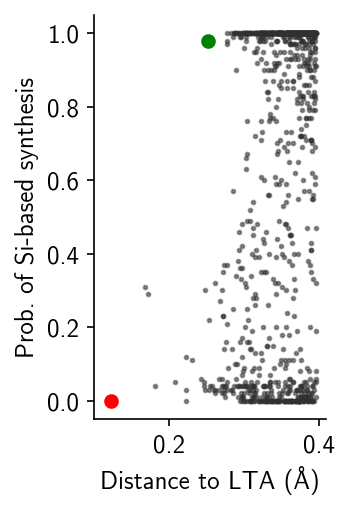

In [143]:
fig, ax = plt.subplots(figsize=(2, 3.5))

ax.scatter(
    _df["LTA"],
    _df["Si"],
    s=3,
    c="#303030",
    alpha=0.5,
)
ax.scatter(
    _df.loc[good_LTA, "LTA"],
    _df.loc[good_LTA, "Si"],
    c='g',
)
ax.scatter(
    _df.loc[bad_LTA, "LTA"],
    _df.loc[bad_LTA, "Si"],
    c='r',
)

ax.set_xlabel("Distance to LTA (Å)", fontsize=12)
ax.set_ylabel("Prob. of Si-based synthesis", fontsize=12)

ax.set_xlim(0.1)

savefig(fig, "06-hyp-lta.pdf")
plt.show()

## Example: finding zeolites based on synthesis conditions

In [188]:
SYNTH_SHOW = ["Al", "Be", "Ge", "K", "Si"]

In [213]:
examples = {
    "Be": 261338,
    "Ge": 64550,
    "K": 303768,
}

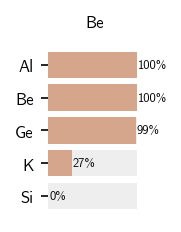

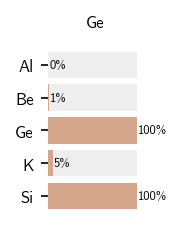

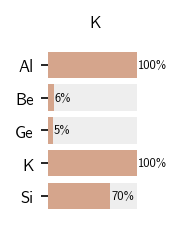

In [219]:
for name, _id in examples.items():
    fig, ax = plt.subplots(figsize=(0.8, 1.5))
    
    _df = final.loc[_id][SYNTH_SHOW]
    
    _y = list(range(len(_df)))[::-1]
    _x = np.ones_like(_y)

    ax.barh(_y, _df.values, color="#D5a58c")
    ax.barh(_y, _x, color="#eeeeee", zorder=-1)

    ax.set_yticks(_y)
    ax.set_yticklabels(_df.index, fontsize=8)
    ax.set_xticks([])

    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    for ypos, xpos in zip(_y, _df.values):
        ax.annotate(
            f"{xpos * 100:.0f}%",
            (xpos + 0.01, ypos),
            xycoords="data",
            fontsize=6,
            va='center',
        )
    ax.set_title(name, fontsize=8)
    
    savefig(fig, f"06-hyp-example-{name}.pdf")
    plt.show()

## Plotting all conditions

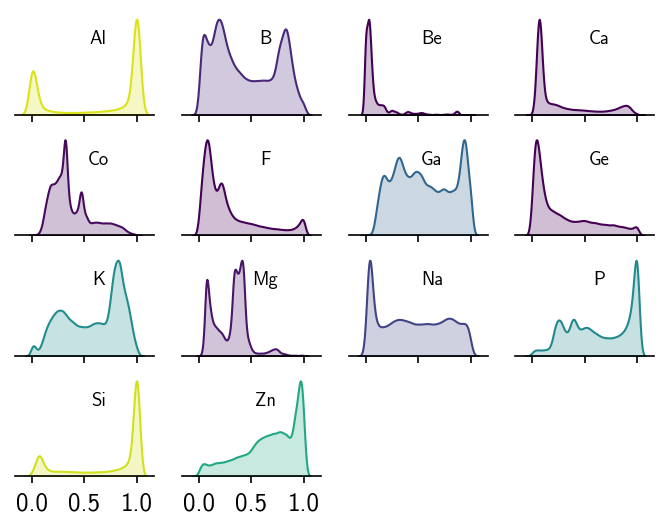

In [245]:
fig, ax_fig = plt.subplots(4, 4, figsize=(5.5, 4), sharex=True)

norm = plt.Normalize(0.3, 1.0)
cmap = cm.viridis

for ax, label in zip(ax_fig.reshape(-1), INORGANICS):
    _df = final[label]
    color = cmap(norm(_df.median()))
    
    sns.kdeplot(_df.values, ax=ax, fill=True, color=color)
    ax.annotate(label, (0.6, 0.85), xycoords="axes fraction", ha="center", va="top", fontsize=9)


for ax in ax_fig.reshape(-1):
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

for ax in ax_fig[-1, :]:
    ax.set_xticks([0, 0.5, 1])
    ax.set_xlabel("")

for ax in ax_fig.reshape(-1)[-2:]:
    ax.axis("off")

savefig(fig, "06-hyp-inorganics.pdf")
plt.show()